#Calibration analysis 
NOTE: not loading strictly not necessary graph to save memory

In [1]:
PYRANOMETERS_ALL = ["Glamorgan", "East Midlands",  "Lazio A", "Lazio B",
           "Trentino Alto Adige tilted", "Trentino Alto Adige horizontal"]
# 22/08/21 TBC why multiple outdoor 2018
CALIBRATIONS_ALL = ["outdoor kz11 e24 2017", "outdoor kz11 e20 2017", "outdoor kz11 e21 2017", "outdoor hfl 2017",
                   "outdoor 2018", "outdoor 2018", "outdoor 2018", "outdoor 2018", "outdoor 2018"]
FILTERS_ALL =["irradiance", "diffuse fraction", "none", "clear sky"]
METHODS_ALL = ["EURAC", "ISO"]

#re-executing only final functions and visualisation outputs using cached variables
execute = ["Trentino Alto Adige horizontal"] + ["diffuse fraction", "none", "clear sky"] + ["ISO"]
#starting with one pyranometer file as example
clb =  "outdoor kz11 e24 2017"
memorysaving = True

In [2]:
#calculated during the execution
#solar libraries
sls = {}
dfs = {}

In [3]:
calibrations = {}

In [4]:
#utc dataframes
dfus = {}

In [5]:
#from preliminary analysis
#initial timezone
tzis = dict(zip(PYRANOMETERS_ALL, ["utc"]*2+["Europe/Rome"]*4))
#datetime delays, summer before winter to keep same convention
dtdsws = dict(zip(PYRANOMETERS_ALL, [None]*2+[(-3600, -7200)]*2+[(-450, -450)]*2))

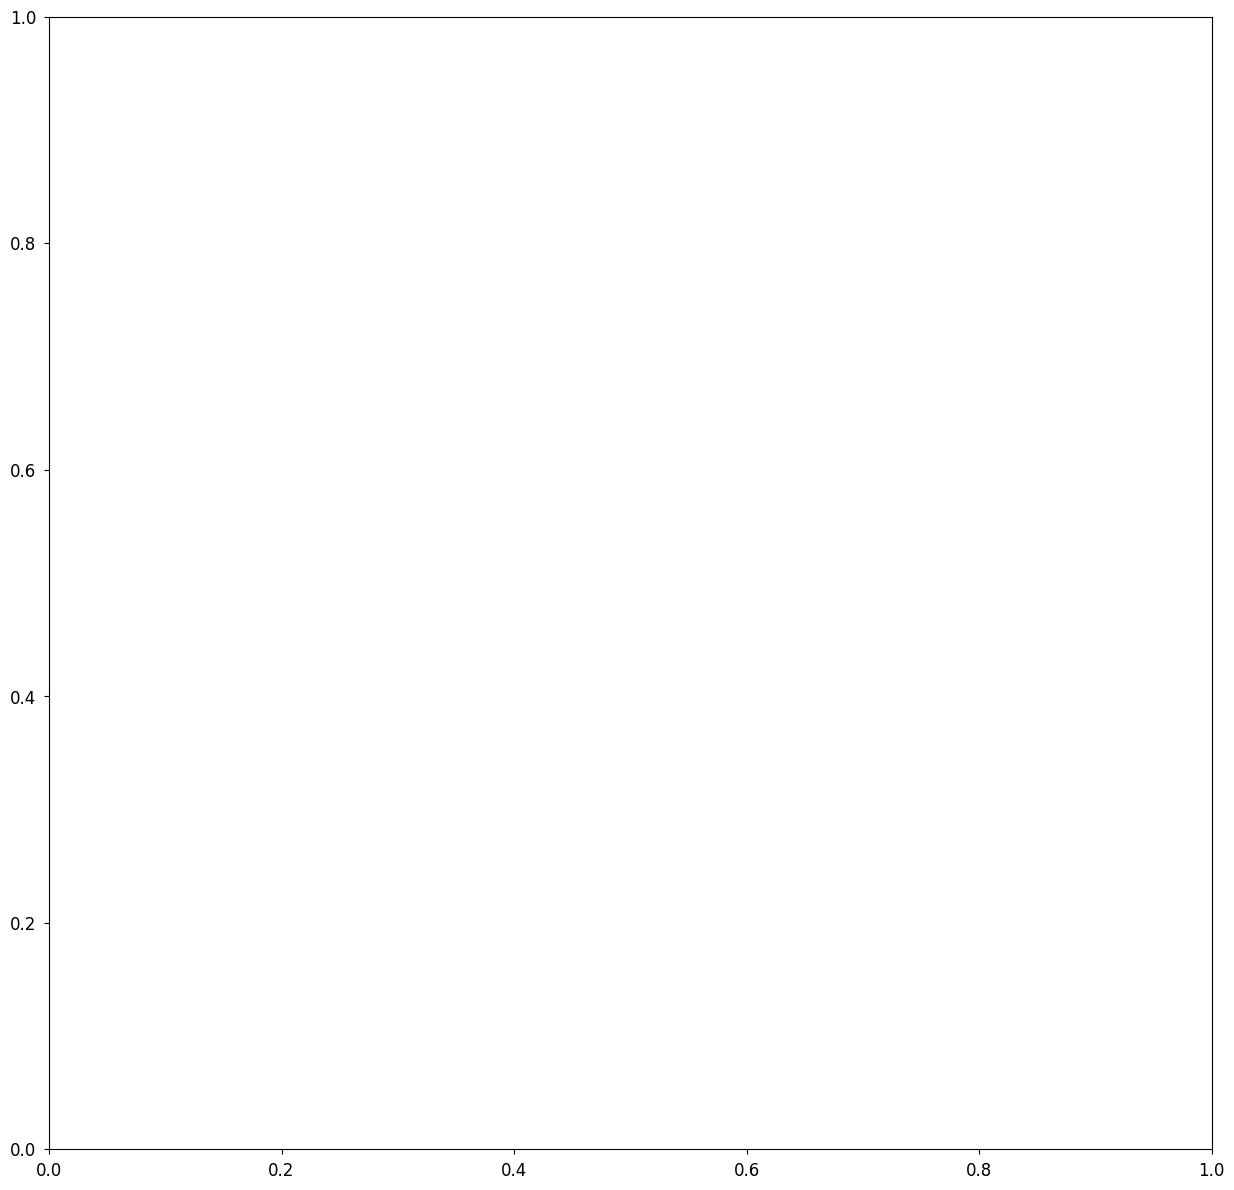

In [6]:
import matplotlib as mpl
#mpl.style.use(['thesis'])

import sys
import pandas as pd
import numpy as np
from typing import List, Dict
from os import getcwd, listdir
from os.path import join, dirname

#for timedelta
import datetime
import data_operations as dtop
import uncertainty as unc
import irradiance_analysis as iran
import irradiance_plot as irplt


import matplotlib.pyplot as plt
import seaborn as sns
#for commonly used decorators
import decorators
LGN_BBOX_TO_ANCHOR =  decorators._DEFAULT_KWARGS[plt.legend]['bbox_to_anchor']
LGN_LOC =  decorators._DEFAULT_KWARGS[plt.legend]['loc']

#for nb specific decorators
import functools

import clear_sky as csky
from clear_sky import SolarLibrary

from mpl_toolkits.axes_grid1 import host_subplot

In [7]:
#excluding store to verify if cause problems
#retrieving stored variables
%store -r
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1
#interrupt when needed
%aimport data_operations, decorators, matplotlib, clear_sky, uncertainty, irradiance_analysis, irradiance_plot

## Setup and data

In [8]:
pd.set_option('display.max_columns', None)
#to solve copy warning
pd.set_option('mode.chained_assignment','raise')

#global filled during execution
FILEPATHS = {}
FOLDERPATHS = {}
COLUMNS: Dict[str, Dict] = {}
CHANNELS = {}

"""STABILITY PARAMETERS (see also irradiance_preliminary_analysis.ipynb)"""
# [ISO 9847]
AOI_MAX = 70
# 0.2 (20%): uncertainty 95% of HOURLY values for moderate quality (class C) radiometers [WMO 2017)
KCS_UNC = 0.2
# 3% (hourly class A) on 1000 also directional response ONLY on class C
G_UNC = 30
# adapted from 2% variation from average in [ISO 9847]
KCS_CV_MAX = 0.02
PWR_CV_MAX = 0.1
# strong correlation used for daily creiteria
PEARSON_MIN = 0.8
# daylight hours IEC 61724-1-2017 but not found in ISO 9847
G_MIN = 20


"""CALIBRATION PARAMETERS"""
TEST_ROWS_NUMBER = None
#gpoa and dt replace global and datetime
COLUMNS_CALIBRATION =["vr_ji","vf_ji","dt","aoi","t_ambient","diffuse","gpoa","wind_speed","azimuth"]
ITERATIONS_MAX = 100 #to deal with errors
DEVIATION_MAX = 0.02 #10/1/20 modified from 2 percentage more correct
COVERAGE_FACTOR = 1.96

#DEV NOTE 22/8/21 but series parameters and filters, should be divided
FILTERS = {}
FILTER_TYPES=["series_count_max","series_minutes","readings_count_min","deviation_max","gpoa_min","beam_min","diffuse_min","diffuse_max","dfraction_max","aoi_max","wind_max"]
#strict requirements while EURAC assigning 0-1 points per requirements based on 9 previous & 10 next measurements (stability) & best series manually selected
FILTERS["ISO"] = dict(zip(FILTER_TYPES, [999,20,20,DEVIATION_MAX, 0,0,0,999,0.2,70,2]))
FILTERS["clear sky"] = dict(zip(FILTER_TYPES, [999,20,20,DEVIATION_MAX,20,0,0,999,0,70,0]))
# see explanation_of_excel_file_for_calculations for original filter
# 700 on irradiance was not there probably added due to Sascha using for PV evaluation
# wind filter actually not used
FILTERS["EURAC"] = dict(zip(FILTER_TYPES, [999,20,20,DEVIATION_MAX, 0,0,10,150,0.15,70,2]))

### CREST data

In [9]:
ISC_IRRADIANCE_FILES_FOLDER = join(dirname(getcwd())+r"/assets/isc_irradiance_files/")

"""CREST INDOOR CALIBRATION PARAMETERS"""

"""CREST INDOOR CALIBRATION DATA"""
FOLDERPATHS["indoor CREST"] = r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/_crest_pyranometer_calibration_indoor/"
#30/5/21 not used, former FILEPATHS_excluded
CREST_FILEPATHS_EXCLUDED = ["WAC-010-20180719160818-CREST000026-000-RESTRICTED.txt",
                 "WAC-010-20180710120633-CREST000091-000-RESTRICTED.txt",
                 "WAC-010-20180103154849-20180103010-000-RESTRICTED.txt",
                 "WAC-010-20171117154318-20171113020-000-RESTRICTED.txt",
                 "WAC-010-20150729191646-20150729000-000-RESTRICTED.txt",
                 "WAC-010-20171218141527-20171113020-000-RESTRICTED.txt",
                 "WAC-010-20171208142548-20171113020-000-RESTRICTED.txt",
                 "WAC-010-20150729191646-20150729000-000-RESTRICTED_NEW.txt",
                 "WAC-010-20150729191646-20150729000-000-RESTRICTED_OLD.txt"
                 # initial tr too high ['"Initial', 'test', '-', 'Analogue', '0-1V', 'logging', '-', 'scales', 'to', 'default', 'range', '-200-2000W/m^2"']
                 ]

### EURAC data

In [10]:
"""EURAC OUTDOOR CALIBRATION PARAMETERS"""
#DEV NOTE 30/5/21 could be improved as dictionary
EURAC_REFERENCE_SENSITIVITY=8.35/10**6


### EURAC data 2017

In [11]:
if clb == "outdoor hfl 2017": raise SystemExit
"""EURAC OUTDOOR CALIBRATION PARAMETERS"""
#ABD reference for filtering (46° 27’ 28’’ N, 11° 19’ 43’’ E, 247 meters above sea level
# 46.464010, 11.330354, 247
#SL 46.458, 11.329, 0
EURAC_RESOLUTION_SECONDS_2017 = 60
EURAC_SL= csky.SolarLibrary(latitude=46.458,longitude=11.329,altitude=247,
                    surface_zenith=0,surface_azimuth=180,timezone="Europe/Rome")

"""EURAC OUTDOOR CALIBRATION DATA"""
DATETIME_FORMAT_EURAC="%d/%m/%Y %H:%M"
FOLDERPATHS["outdoor EURAC 2017"] =( #path to eurac folder
"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/170530-170614_eurac_calibration/")
FILEPATHS["outdoor kz11 e24 2017"] = join(FOLDERPATHS["outdoor EURAC 2017"],"calibration_calculations_Ch4_fm_181122.csv") 
FILEPATHS["outdoor kz11 e20 2017"]= join(FOLDERPATHS["outdoor EURAC 2017"],"calibration_calculations_Ch5_fm_181122.csv")#
FILEPATHS["outdoor kz11 e21 2017"]= join(FOLDERPATHS["outdoor EURAC 2017"],"calibration_calculations_Ch6_fm_181122.csv") 
FILEPATHS["outdoor hfl 2017"]= join(FOLDERPATHS["outdoor EURAC 2017"],"calibration_calculations_Ch7_fm_181122.csv") 

COLUMNS_OUTDOOR_2017 = ["PYR_REF_Ch3 raw","CH raw","date","Zenith angle (ETR) SolPos","T_ambient scaled",
"CMP11_diffuse scaled","CMP11_global_horiz scaled","Gill_wind_speed scaled","Azimuth angle SolPos"]

CHANNELS["outdoor chp 2017"] = "CHP1_direct scaled"
CHANNELS["outdoor kz11 e24 2017"] = "PYR_TEST_Ch4 raw"
CHANNELS["outdoor kz11 e20 2017"]=  "PYR_TEST_Ch5 raw"
CHANNELS["outdoor kz11 e21 2017"]=  "PYR_TEST_Ch6 raw"
CHANNELS["outdoor hfl 2017"]= "PYR_TEST_Ch7 raw"

for cl in [c for c in CALIBRATIONS_ALL if "2017" in c]:
    file_columns = [CHANNELS[clb] if x=="CH raw" else x for x in COLUMNS_OUTDOOR_2017]
    COLUMNS[cl] = dict(zip(file_columns, COLUMNS_CALIBRATION))

#EURAC CALIBRATION SERIES (MANUAL)
#ref calibration_calculations_Ch4_210610_fm
# not clear why some filtered values taken and other ones not

s1=[1,'31/05/2017 13:11','31/05/2017 13:31']
s10=[10,'03/06/2017 11:34','03/06/2017 11:54']
s100=[100,'12/06/2017 10:11','12/06/2017 10:31']
s101=[101,'12/06/2017 10:31','12/06/2017 10:51']
s102=[102,'12/06/2017 10:51','12/06/2017 11:11']
s103=[103,'12/06/2017 11:11','12/06/2017 11:31']
s104=[104,'12/06/2017 11:31','12/06/2017 11:51']
s105=[105,'12/06/2017 11:51','12/06/2017 12:11']
s106=[106,'12/06/2017 14:33','12/06/2017 14:53']
s107=[107,'12/06/2017 15:37','12/06/2017 15:57']
s108=[108,'13/06/2017 10:52','13/06/2017 11:12']
s109=[109,'13/06/2017 11:12','13/06/2017 11:32']
s11=[11,'03/06/2017 11:54','03/06/2017 12:14']
s110=[110,'13/06/2017 11:32','13/06/2017 11:52']
s111=[111,'13/06/2017 11:52','13/06/2017 12:12']
s12=[12,'04/06/2017 15:58','04/06/2017 16:18']
s13=[13,'04/06/2017 16:18','04/06/2017 16:38']
s14=[14,'04/06/2017 16:38','04/06/2017 16:58']
s15=[15,'04/06/2017 16:58','04/06/2017 17:18']
s16=[16,'04/06/2017 17:18','04/06/2017 17:38']
s17=[17,'04/06/2017 17:38','04/06/2017 17:58']
s18=[18,'07/06/2017 08:05','07/06/2017 08:25']
s19=[19,'07/06/2017 08:25','07/06/2017 08:45']
s2=[2,'03/06/2017 08:54','03/06/2017 09:14']
s20=[20,'07/06/2017 08:45','07/06/2017 09:05']
s21=[21,'07/06/2017 09:05','07/06/2017 09:25']
s22=[22,'07/06/2017 09:25','07/06/2017 09:45']
s23=[23,'07/06/2017 09:45','07/06/2017 10:05']
s24=[24,'07/06/2017 10:05','07/06/2017 10:25']
s25=[25,'07/06/2017 10:25','07/06/2017 10:45']
s26=[26,'07/06/2017 10:45','07/06/2017 11:05']
s27=[27,'07/06/2017 11:05','07/06/2017 11:25']
s28=[28,'07/06/2017 11:25','07/06/2017 11:45']
s29=[29,'07/06/2017 11:45','07/06/2017 12:05']
s3=[3,'03/06/2017 09:14','03/06/2017 09:34']
s30=[30,'07/06/2017 12:05','07/06/2017 12:25']
s31=[31,'07/06/2017 12:25','07/06/2017 12:45']
s32=[32,'07/06/2017 12:45','07/06/2017 13:05']
s33=[33,'07/06/2017 13:05','07/06/2017 13:25']
s34=[34,'07/06/2017 13:25','07/06/2017 13:45']
s35=[35,'07/06/2017 13:45','07/06/2017 14:05']
s36=[36,'07/06/2017 14:05','07/06/2017 14:25']
s37=[37,'07/06/2017 14:25','07/06/2017 14:45']
s38=[38,'07/06/2017 17:25','07/06/2017 17:45']
s39=[39,'08/06/2017 13:55','08/06/2017 14:15']
s4=[4,'03/06/2017 09:34','03/06/2017 09:54']
s40=[40,'08/06/2017 16:21','08/06/2017 16:41']
s41=[41,'08/06/2017 16:41','08/06/2017 17:01']
s42=[42,'08/06/2017 17:01','08/06/2017 17:21']
s43=[43,'08/06/2017 17:21','08/06/2017 17:41']
s44=[44,'08/06/2017 17:41','08/06/2017 18:01']
s45=[45,'08/06/2017 18:01','08/06/2017 18:21']
s46=[46,'08/06/2017 18:21','08/06/2017 18:41']
s47=[47,'09/06/2017 08:07','09/06/2017 08:27']
s48=[48,'09/06/2017 08:27','09/06/2017 08:47']
s49=[49,'09/06/2017 08:47','09/06/2017 09:07']
s5=[5,'03/06/2017 09:54','03/06/2017 10:14']
s50=[50,'09/06/2017 09:07','09/06/2017 09:27']
s51=[51,'09/06/2017 09:27','09/06/2017 09:47']
s52=[52,'09/06/2017 09:47','09/06/2017 10:07']
s53=[53,'09/06/2017 10:07','09/06/2017 10:27']
s54=[54,'09/06/2017 10:27','09/06/2017 10:47']
s55=[55,'09/06/2017 10:47','09/06/2017 11:07']
s56=[56,'10/06/2017 09:08','10/06/2017 09:28']
s57=[57,'10/06/2017 09:28','10/06/2017 09:48']
s58=[58,'10/06/2017 12:36','10/06/2017 12:56']
s59=[59,'10/06/2017 12:56','10/06/2017 13:16']
s6=[6,'03/06/2017 10:14','03/06/2017 10:34']
s60=[60,'10/06/2017 13:16','10/06/2017 13:36']
s61=[61,'10/06/2017 13:36','10/06/2017 13:56']
s62=[62,'10/06/2017 13:56','10/06/2017 14:16']
s63=[63,'10/06/2017 14:16','10/06/2017 14:36']
s64=[64,'10/06/2017 14:36','10/06/2017 14:56']
s65=[65,'10/06/2017 14:56','10/06/2017 15:16']
s66=[66,'10/06/2017 15:49','10/06/2017 16:09']
s67=[67,'10/06/2017 16:09','10/06/2017 16:29']
s68=[68,'10/06/2017 16:29','10/06/2017 16:49']
s69=[69,'10/06/2017 17:00','10/06/2017 17:20']
s7=[7,'03/06/2017 10:34','03/06/2017 10:54']
s70=[70,'10/06/2017 17:21','10/06/2017 17:41']
s71=[71,'10/06/2017 17:42','10/06/2017 18:02']
s72=[72,'11/06/2017 08:17','11/06/2017 08:37']
s73=[73,'11/06/2017 08:37','11/06/2017 08:57']
s74=[74,'11/06/2017 08:57','11/06/2017 09:17']
s75=[75,'11/06/2017 09:17','11/06/2017 09:37']
s76=[76,'11/06/2017 09:37','11/06/2017 09:57']
s77=[77,'11/06/2017 09:57','11/06/2017 10:17']
s78=[78,'11/06/2017 10:17','11/06/2017 10:37']
s79=[79,'11/06/2017 10:37','11/06/2017 10:57']
s8=[8,'03/06/2017 10:54','03/06/2017 11:14']
s80=[80,'11/06/2017 10:57','11/06/2017 11:17']
s81=[81,'11/06/2017 11:17','11/06/2017 11:37']
s82=[82,'11/06/2017 11:37','11/06/2017 11:57']
s83=[83,'11/06/2017 11:57','11/06/2017 12:17']
s84=[84,'11/06/2017 12:17','11/06/2017 12:37']
s85=[85,'11/06/2017 12:37','11/06/2017 12:57']
s86=[86,'11/06/2017 12:57','11/06/2017 13:17']
s87=[87,'11/06/2017 13:17','11/06/2017 13:37']
s88=[88,'11/06/2017 13:37','11/06/2017 13:57']
s89=[89,'11/06/2017 13:57','11/06/2017 14:17']
s9=[9,'03/06/2017 11:14','03/06/2017 11:34']
s90=[90,'11/06/2017 14:17','11/06/2017 14:37']
s91=[91,'11/06/2017 14:46','11/06/2017 15:06']
s92=[92,'11/06/2017 15:06','11/06/2017 15:26']
s93=[93,'11/06/2017 15:26','11/06/2017 15:46']
s94=[94,'11/06/2017 15:46','11/06/2017 16:06']
s95=[95,'11/06/2017 16:06','11/06/2017 16:26']
s96=[96,'11/06/2017 16:26','11/06/2017 16:46']
s97=[97,'11/06/2017 16:46','11/06/2017 17:06']
s98=[98,'11/06/2017 17:16','11/06/2017 17:36']
s99=[99,'12/06/2017 09:51','12/06/2017 10:11']

clb_ses_2017=[s1,s8,s9,s10,s11,s27,s28,s29,s30,s32,s33,s34,s35,s36,s37,s60,s62,s63,s64,s80,s82,s83,s84,s85,s86,s87,s88,
              s89,s103,s104,s109,s110]

flt_ses_2017 = [s1, s2, s3, s4, s5, s6, s7, s8, s9, s10, s11, s12, s13, s14, s15, s16, s17, s18, s19, s20, s21, s22,
                s23, s24, s25, s26, s27, s28, s29, s30, s31, s32, s33, s34, s35, s36, s37, s38, s39, s40, s41, s42, 
                s43, s44, s45, s46, s47, s48, s49, s50, s51, s52, s53, s54, s55, s56, s57, s58, s59, s60, s61, s62, 
                s63, s64, s65, s66, s67, s68, s69, s70, s71, s72, s73, s74, s75, s76, s77, s78, s79, s80, s81, s82, 
                s83, s84, s85, s86, s87, s88, s89, s90, s91, s92, s93, s94, s95, s96, s97, s98, s99, s100, s101, 
                s102, s103, s104, s105, s106, s107, s108, s109, s110, s111]

def get_start_end(s: List[List], dt_format:str):
    df = pd.DataFrame([item for item in s],columns=["id","start","end"])
    for c in ["start", "end"]: df.loc[:,c]=df.loc[:,c].apply(
        lambda x:pd.to_datetime(x,format=dt_format))
    print(len(df))
    return df

if "EURAC" in execute:
    CALIBRATION_SERIES_2017 = get_start_end(clb_ses_2017, DATETIME_FORMAT_EURAC)
    FILTERED_SERIES_2017 = get_start_end(flt_ses_2017, DATETIME_FORMAT_EURAC)

### EURAC data 2018 TBC

In [12]:
if clb == "outdoor hfl 2017": raise SystemExit
EURAC_RESOLUTION_SECONDS_2018 = 5

"""FOLDERPATHS["outdoor 2018"]=(
"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/181115-181205_crest_at_eurac_calibration_outdoor/")

#30/5/21 TBC
EURAC_FILE_irradiance_2018="Irradiation_df_01_15211118.csv"
EURAC_FILE_CH_2018="PyranometerCalib_15211118.csv"
#cmp21_c18_c5_18 in tc5, cmp11_c12_c0_18 in tc0, cmp11_c13_c1_18 in tc1
#cmp11_e46_c3_18 in tc2, cmp11_e48_c4_18 in tc4 (horizontal at abd)
#101850 not available
#2018: "cmp21","cmp11_c12","cmp11_c13","vr_ji","cmp11_e46","cmp11_e48"
#2018: "tc5","tco","tc1","tc2","tc3","tc4"""


'FOLDERPATHS["outdoor 2018"]=(\n"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/181115-181205_crest_at_eurac_calibration_outdoor/")\n\n#30/5/21 TBC\nEURAC_FILE_irradiance_2018="Irradiation_df_01_15211118.csv"\nEURAC_FILE_CH_2018="PyranometerCalib_15211118.csv"\n#cmp21_c18_c5_18 in tc5, cmp11_c12_c0_18 in tc0, cmp11_c13_c1_18 in tc1\n#cmp11_e46_c3_18 in tc2, cmp11_e48_c4_18 in tc4 (horizontal at abd)\n#101850 not available\n#2018: "cmp21","cmp11_c12","cmp11_c13","vr_ji","cmp11_e46","cmp11_e48"\n#2018: "tc5","tco","tc1","tc2","tc3","tc4'

In [13]:
"""GRAPHICAL FUNCTIONS """
#2/6/21 TBC if and how implement in other modules

def get_mscs_by_day(ms: pd.DataFrame, sl:SolarLibrary, tzi='utc'):
    #first one assuming for cs
    #copy to be safe
    try:
        dti = pd.DatetimeIndex(ms.dt, tz=tzi)
    except KeyError:
        dti = pd.DatetimeIndex(ms.dt)
    dti = dti.tz_convert(tz='utc')
    ms.index = dti
    ms["date"] = dti.date
    cs_dates = ms.date.unique()
    titles = [f'{d.strftime("%d/%m/%y")}' for d in cs_dates]
    mscs = csky.merge_meas_with_sp(ms, sl)
    mscss = []
    for d in cs_dates:
        mscss.append(mscs[mscs.date==d])
    return mscss, titles

def plot_stable_days(mss: List[pd.DataFrame], sl:SolarLibrary, tzi:str='utc',
                      markers:List[str]=["b--","r.","k.", "g."],
                      lgn_labels:List[str] = ["clear sky", "excluded", "filtered", "calibration"],
                      columns:List[str] = ["irradiancetotalpoa","excluded","filtered", "calibration"], label:str=None,
                      bbox_to_anchor=LGN_BBOX_TO_ANCHOR, loc=0,
                      plt_prm=''):
    #lazy could be merged
    suptitle = f"Calibration days measurements against clear sky {label if label is not None else ''}"


    mscss, titles = get_mscs_by_day(mss, sl, tzi=tzi)
    irplt.plot_daily_measurements(mscss=mscss, titles=titles, lgn_labels=lgn_labels, suptitle=suptitle,
                            columns=columns, markers=markers, bbox_to_anchor=bbox_to_anchor, loc=loc, plt_prm=plt_prm)

TBC visualisation could be done, risk overlaps
## Reading and cleaning dataset

### East Midlands system
When evaluating outdoor calibration

In [14]:
if "East Midlands" in execute:
    sst = "East Midlands"
    if sst == "East Midlands":
        #one minute steps extracted (one second available)
        #DEV NOTE 29/5/21 based on DST days, one second rsl could be extracted from SQL if only four days taken
        #gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20.csv'))
        gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20m.csv'))
        print(gpoa.head(2))
        print(gpoa.tail(1))


##  Analysis of filter impact on outdoor calibration campaign (EURAC, 2017)


### Loading data
As comparison, theoretically not valid since lower elevation missing

In [15]:
#starting with one pyranometer file as example
calibrations[clb] = {}
if "2017" in clb:
    rqr=FILTERS["EURAC"]
    reference_sensitivity=EURAC_REFERENCE_SENSITIVITY
    reference_calibration_factor=1/reference_sensitivity
    sl = EURAC_SL
    print(rqr)

{'series_count_max': 999, 'series_minutes': 20, 'readings_count_min': 20, 'deviation_max': 0.02, 'gpoa_min': 0, 'beam_min': 0, 'diffuse_min': 10, 'diffuse_max': 150, 'dfraction_max': 0.15, 'aoi_max': 70, 'wind_max': 2}


In [16]:
#starting with one pyranometer as example
if "2017" in clb :
    resolution = EURAC_RESOLUTION_SECONDS_2017    
    filepath = FILEPATHS[clb]
    usecols, columns  = [k for k in COLUMNS[clb].keys()], COLUMNS[clb]
    #280520 modify name depending on file
    df = pd.read_csv(filepath, header=0, skiprows=0, usecols=usecols, nrows=TEST_ROWS_NUMBER)
    df.rename(columns=columns, inplace=True)
    #first two rows to verify time steps
    print(df.head(2))

                 dt  t_ambient     diffuse        gpoa    vf_ji    vr_ji  \
0  30/05/2017 14:57  31.392517  222.023406  221.340013  1.63070  1.61331   
1  30/05/2017 14:58  30.947447  219.094995  218.304756  1.60494  1.58828   

   wind_speed   azimuth      aoi  
0         NaN  229.6892  32.4857  
1         NaN  230.0441  32.6172  


In [17]:
#calculating support values
df["diffuse_fraction"]=df["diffuse"]/df["gpoa"]
df["beam"]=df["gpoa"]-df["diffuse"]#
df.loc[:,"dt"]=df.loc[:,"dt"].apply(lambda x:pd.to_datetime(x,format=DATETIME_FORMAT_EURAC))
#localize timezone later
df.loc[:,"dt"]=pd.DatetimeIndex(df.loc[:,"dt"])
df.sort_values(by="dt", inplace=True)

In [18]:
#utc conversion before clear sky analysis
#to be run only once otherwise TypeError: data is already tz-aware UTC, unable to set specified tz: Europe/Rome
dti = pd.DatetimeIndex(df.loc[:, "dt"], tz=EURAC_SL.timezone).tz_convert(tz='utc')
df.loc[:, "dt"] = dti
df.index = dti

In [19]:
if "EURAC" in execute:
    #converting series as well
    s_tmp = [CALIBRATION_SERIES_2017.start, CALIBRATION_SERIES_2017.end,
             FILTERED_SERIES_2017.start, FILTERED_SERIES_2017.end]
    #iteration not working, doing manually
    for s in s_tmp:
        print(type(s))
        try: s = pd.DatetimeIndex(s, tz=EURAC_SL.timezone).tz_convert(tz='utc')
        except TypeError: print(f"{s.name} already tz")
    CALIBRATION_SERIES_2017.start = pd.DatetimeIndex(CALIBRATION_SERIES_2017.start, tz=EURAC_SL.timezone).tz_convert(tz='utc')
    CALIBRATION_SERIES_2017.end = pd.DatetimeIndex(CALIBRATION_SERIES_2017.end, tz=EURAC_SL.timezone).tz_convert(tz='utc')
    FILTERED_SERIES_2017.start = pd.DatetimeIndex(FILTERED_SERIES_2017.start, tz=EURAC_SL.timezone).tz_convert(tz='utc')
    FILTERED_SERIES_2017.end = pd.DatetimeIndex(FILTERED_SERIES_2017.end, tz=EURAC_SL.timezone).tz_convert(tz='utc')

In [20]:

def get_excluded_filter_calibration(df:pd.DataFrame, flt_df:pd.DataFrame=None,
                                    clb_df:pd.DataFrame=None) -> pd.DataFrame:
    #deep copy just in case
    df_lbl = df.copy(deep=True)
    clb_dt = pd.Series()
    if clb_df is not None:
        if all([c in clb_df.columns.to_list() for c in ["start", "end"]]): 
            for i, r in clb_df.iterrows():
                clb_dt_r = df_lbl.loc[(df_lbl['dt']>=r['start'])&(df_lbl['dt']<r['end']),'dt']
                clb_dt = clb_dt.append(clb_dt_r)
        else:
            clb_dt = pd.Series(clb_df.dt.values)
    flt_dt= pd.Series()
    #DEV NOTE: repetitive could be simplified
    if flt_df is not None:
        if all([c in flt_df.columns.to_list() for c in ["start", "end"]]):
            for i, r in flt_df.iterrows():
                flt_dt= flt_dt.append(df_lbl.loc[(df_lbl["dt"]>=r["start"])&(df_lbl["dt"]<r["end"]),"dt"])
            flt_dt= flt_dt[flt_dt.isin(clb_dt)==False]
        else:
            flt_dt = pd.Series(flt_df.dt.values)
    exc_dt = df_lbl.loc[(df_lbl.dt.isin(flt_dt)==False) & (df_lbl.dt.isin(clb_dt)==False),"dt"]
    for c, dts in zip(["excluded","filtered", "calibration"], [exc_dt, flt_dt, clb_dt]):
        df_lbl[c] = df_lbl.apply(lambda x: x["gpoa"], axis=1)
        df_lbl.loc[df_lbl.dt.isin(dts) == False, c] = None
    return df_lbl



def get_calibration_factors(df_flt:pd.DataFrame, method ="9847 1a", deviation_max = DEVIATION_MAX,
                           itr = 1, steps = [""], periods = ["20min"], counts = [20],
                           kcs_uncs = [None], pearson_mins = [None], kcs_cv_maxs = [None]) -> pd.DataFrame:
    # separately defining the ones not needing comments
    (ms_tz, sl, g_mins, aoi_maxs) = (df_flt, EURAC_SL, [G_MIN] * itr, [AOI_MAX] * itr)
    ms, ms_flt, ms_grps = csky.stabilityflagging(ms_utc=df_flt, sl=sl, steps=steps, periods=periods, counts=counts,
                                             kcs_uncs=kcs_uncs, pearson_mins=pearson_mins,
                                             kcs_cv_maxs=kcs_cv_maxs, g_mins=g_mins, aoi_maxs=aoi_maxs)
    # taking df merged with info grouping period 20 min and count 20 (in this case only one type df)
    # TBC label to be adapted if additional periods and counts added ?
    t = ms_grps["s_p20min_c20"].copy()
    #removing nan (TBC why exist for no filter)
    t.dropna(subset=["g_stable_p_20min"], inplace=True)
    #taking only values where g_stable_p_20_min is true (minimum 20 values)
    ta = t[t.g_stable_p_20min].groupby("dt_p_20min").agg({"dt_p_20min":[min]})
    #recreating list of series
    flt_id_start_end = pd.DataFrame()
    flt_id_start_end["start"] = ta.values
    flt_id_start_end["end"] = flt_id_start_end.start.apply(lambda x: x + datetime.timedelta(minutes=20))
    flt_id_start_end["id"] = flt_id_start_end.index
    srs_calibration_factors = unc.get_calibration_factors(df=df_flt,
                                 srs_id_start_end=flt_id_start_end,
            reference_column="vr_j",
            field_column="vf_j",
            calibration_factor=reference_calibration_factor,
            method=method,
            deviation_max=deviation_max,
            readings_min=filters["readings_count_min"],  # for eurac
            iterations_max=ITERATIONS_MAX,
            log=False,
            median=False)
    f = srs_calibration_factors.f_j.mean()
    s = 1/f * (10**6)
    print(f"calibration factor {f}, sensitivity {s}")
    return flt_id_start_end, srs_calibration_factors, f, s

### Calculating the calibration factor based on EURAC manually filtered series
Filtered series based on having at least 20 one minute consecutive valid values
Calibration series based on the evaluation of the (max-min)/avg < 2*2% of the REFERENCE sensor
such requirement is stricter for lower elevation when percentage variation is higher comparing to zenith
however it is a good inspiration to replace it with kcs stability

RESULT: EURAC filter on reference sensor quite strict results only in lower AOI cases

In [21]:
#importing filters and setup
if "EURAC" in execute:
    filters = FILTERS["EURAC"]
    print(filters)

    srs_calibration_factors_2017 = unc.get_calibration_factors(df=df,
                                     srs_id_start_end=CALIBRATION_SERIES_2017,
                reference_column="vr_j",
                field_column="vf_j",
                calibration_factor=reference_calibration_factor,
                method="9847 1a EURAC",
                deviation_max=DEVIATION_MAX,
                readings_min=filters["readings_count_min"],  # for eurac
                iterations_max=ITERATIONS_MAX,
                log=False,
                median=False)

In [22]:
if "EURAC" in execute:
    clb_flt = clb+" EURAC"
    #DEV NOTE 22/08/21 deleting if already there in case
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    calibrations[clb_flt]["filters"] = FILTERS["EURAC"]
    f = srs_calibration_factors_2017.f_j.mean()
    calibrations[clb_flt]["calibration_f"] = f
    calibrations[clb_flt]["sensitivity"] = 1/f * (10**6)
    print(f"calibration factor {calibrations[clb_flt]['calibration_f']}, sensitivity {calibrations[clb_flt]['sensitivity']}")
    # filtered series include already series with only 20 elements
    calibrations[clb_flt]["flt_series"] = FILTERED_SERIES_2017
    calibrations[clb_flt]["clb_series"] =  CALIBRATION_SERIES_2017
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df, FILTERED_SERIES_2017, CALIBRATION_SERIES_2017)

In [23]:
if "EURAC" in execute:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "", #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')


### Calculating the calibration factor based on EURAC filter and method but automatically

In [24]:
if "EURAC" in execute:
    filters = FILTERS["EURAC"]
    # no filter on beam df["beam"] >= filters["beam_min"]) &
    df_flt = df[(df["diffuse"] > filters["diffuse_min"]) & (df["diffuse"] < filters["diffuse_max"]) &
                (df["beam"] > filters["beam_min"]) &
                (df["diffuse_fraction"] < filters["dfraction_max"]) &
                (df["aoi"] <= filters["aoi_max"])].copy()


In [25]:
if "EURAC" in execute:
    clb_flt = clb+" eurac auto"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    calibrations[clb_flt]["filters"] = FILTERS["EURAC"]
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = (get_calibration_factors(df_flt, method="9847 1a EURAC"))
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

In [26]:
if "EURAC" in execute:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "", #(Trentino Alto Adige, summer 2017)",
                         loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')

automatic procedure results very similar result although one day missed (31/5/21)
probably more restrictive than ISO

### Calculating the calibration factor based on EURAC filter but iso method
filters and df_flt previously defined

In [27]:
if "irradiance" in execute:
    clb_flt = clb+" irradiance filter"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    calibrations[clb_flt]["filters"] = FILTERS["EURAC"]
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = (get_calibration_factors(df_flt, method="9847 1a"))
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

In [28]:
if "irradiance" in execute:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "", #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')


### Relculating the calibration factor automatically using only ISO 0.2 diffuse fraction and 20 W/m2
diffuse fraction 0.15 requirements is the only one needed to get same results of EURAC. See also:
"calibrations[clb+" eurac iso"]["clb_series"].equals(calibrations[clb_flt]["clb_series"])"
lighter diffuse fraction requirements of course result in more calibration series.

In [29]:
if "diffuse fraction" in execute:
    filters = FILTERS["ISO"]
    filters["dfraction_max"] = 0.20
    filters["gpoa_min"] = 20
    filters

In [30]:
if "diffuse fraction" in execute:
    # no filter on beam df["beam"] >= filters["beam_min"]) &
    #df_flt_irr = df[(df["diffuse"] > filters["diffuse_min"]) & (df["diffuse"] < filters["diffuse_max"]) &
    #            (df["diffuse_fraction"] < filters["dfraction_max"]) &
    #            (df["aoi"] <= filters["aoi_max"])].copy()
    df_flt = df[(df["diffuse_fraction"] < filters["dfraction_max"]) &
                    (df["aoi"] <= filters["aoi_max"]) &
                    (df["gpoa"] > filters["gpoa_min"])].copy()

In [31]:
if "diffuse fraction" in execute:
    clb_flt = clb+" diffuse fraction < 0.2"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    calibrations[clb_flt]["filters"] = FILTERS["EURAC"]
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = (get_calibration_factors(df_flt, method="9847 1a"))
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

Started 'stabilityflagging' at 2021-08-25 17:45:13.927763
3416 rows. Extracting  data before 20min grouping of min 20 valid values
Started 'get_parameters_timed' at 2021-08-25 17:45:14.570799
Finished 'get_parameters_timed' in 0:00:01.411967 secs
Validation done with g_min,aoi_max. Filtering for values count
Returning 2820 rows in filtered dataset.
Finished 'stabilityflagging' in 0:00:02.083055 secs
calibration factor 118738.53286464438, sensitivity 8.421865892009519


c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


In [32]:
if "diffuse fraction" in execute and memorysaving == False:
    #filter TBC
    #utc 0:00 instead of Europe si,nce alreay
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "", #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')

### Calculating the calibration factor using only irradiance > 20 W/m2
importance of having cloud ratio filter showed by not using at all

In [33]:
if "none" in execute:
    filters = FILTERS["ISO"]
    filters["dfraction_max"] = 999
    filters["gpoa_min"] = 20
    filters

In [34]:
if "none" in execute:
    df_flt = df[(df["diffuse_fraction"] < filters["dfraction_max"]) &
                    (df["aoi"] <= filters["aoi_max"]) &
                    (df["gpoa"] > filters["gpoa_min"])].copy()

In [35]:
if "none" in execute:
    clb_flt = clb+" irradiance > 20 W/m2"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    #TBI actually filter higher than 20 W there
    calibrations[clb_flt]["filters"] = None
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = (get_calibration_factors(df, method="9847 1a"))
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

Started 'stabilityflagging' at 2021-08-25 17:45:21.918819
21888 rows. Extracting  data before 20min grouping of min 20 valid values
Started 'get_parameters_timed' at 2021-08-25 17:45:23.048856
Finished 'get_parameters_timed' in 0:00:01.788000 secs
Validation done with g_min,aoi_max. Filtering for values count
Returning 9900 rows in filtered dataset.
Finished 'stabilityflagging' in 0:00:02.958004 secs
calibration factor 118930.551884351, sensitivity 8.408268389878556


c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


In [36]:
if "none" in execute and memorysaving == False:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "",
                             #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')

In [37]:
if "none" in execute and "EURAC" in execute:
    #testing irradiance but with EURAC method
    clb_flt = clb+" eurac irradiance > 20 W/m2"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    #TBI actually filter higher than 20 W there
    calibrations[clb_flt]["filters"] = None
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = (get_calibration_factors(df, method="EURAC 9847 1a"))
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

In [38]:
if "none" in execute and "EURAC" in execute and memorysaving == False:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "",
                             #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')

Not so surprising that calibration factors are still calculated despite no filter
calibration factors are based on relationship between sensors first
if same design more likely 


### Calculating the calibration factor using the clear sky stability filter
stability one hour tried but it doesn't seems to improve a lot situation
tried also to reduce kcs but still diffuse fraction up to 0.35 showing up
avoid filter aoi before that otherwise first and last measurements AOI > 70 always excluded


In [39]:
#using same filter as before ISO without dfraction
if "clear sky" in execute:
    filters = FILTERS["ISO"]
    filters["dfraction_max"] = 999
    filters["gpoa_min"] = 20
    filters

In [40]:
if "clear sky" in execute:
    df_flt = df[(df["diffuse_fraction"] < filters["dfraction_max"]) &
                    (df["aoi"] <= filters["aoi_max"]) &
                    (df["gpoa"] > filters["gpoa_min"])].copy()

In [41]:
if "clear sky" in execute:
    clb_flt = clb+" clear sky filter"
    if clb_flt in calibrations.keys(): del calibrations[clb_flt]
    calibrations[clb_flt] = {}
    #TBI actually filter higher than 20 W there
    calibrations[clb_flt]["filters"] = None
    (calibrations[clb_flt]["flt_series"],calibrations[clb_flt]["clb_series"], calibrations[clb_flt]["calibration_f"],
    calibrations[clb_flt]["sensitivity"]) = get_calibration_factors(df, method ="9847 1a", deviation_max = DEVIATION_MAX,
                               itr = 1, steps = [""], periods = ["20min"], counts = [20],
                               kcs_uncs = [KCS_UNC], pearson_mins = [None], kcs_cv_maxs = [KCS_CV_MAX])
    calibrations[clb_flt]["labeled_df"] = get_excluded_filter_calibration(df,
    calibrations[clb_flt]["flt_series"], calibrations[clb_flt]["clb_series"])

Started 'stabilityflagging' at 2021-08-25 17:45:44.427959
21888 rows. Extracting  data before 20min grouping of min 20 valid values
Started 'get_parameters_timed' at 2021-08-25 17:45:45.478434
Finished 'get_parameters_timed' in 0:00:01.450543 secs
Validation done with g_min,aoi_max,kcs_unc. Filtering for values count,kcs std
Returning 2540 rows in filtered dataset.
Finished 'stabilityflagging' in 0:00:02.531015 secs
calibration factor 118651.68561102195, sensitivity 8.42803028756219


c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


In [42]:
if "clear sky" in execute and memorysaving == False:
    mscss = plot_stable_days(calibrations[clb_flt]["labeled_df"], sl=EURAC_SL, tzi='utc', label= "",
                             #(Trentino Alto Adige, summer 2017)",
                             loc=(0,0), bbox_to_anchor=(0,-1)) #, plt_prm=f'loc{str(i)}')

## Comparing all calibration factors

### Overview of calibration days

In [43]:
columns = ["excluded", "filtered", "calibration"]
clb_flt = clb + " diffuse fraction < 0.2"
#taking all columns to review results
labeled_dfs = calibrations[clb_flt]["labeled_df"]
clb_flt = clb + " clear sky filter"
labeled_dfs = pd.merge(left=labeled_dfs, right=calibrations[clb_flt]["labeled_df"][columns], suffixes=("_df","_cs"),
         left_index=True, right_index=True)
clb_flt = clb + " irradiance > 20 W/m2"
#no need of suffix since columns changed before
labeled_dfs = pd.merge(left=labeled_dfs, right=calibrations[clb_flt]["labeled_df"][columns],
         left_index=True, right_index=True)

In [44]:
clb_clm_ind = {
"clb_no_filter": (labeled_dfs.calibration>0)&(labeled_dfs.calibration_cs.isna())&(labeled_dfs.calibration_df.isna()),
"clb_flt_cs_df": (labeled_dfs.calibration_df>0)&(labeled_dfs.calibration_cs>0),
"clb_flt_df": (labeled_dfs.calibration_df>0)&(labeled_dfs.calibration_cs.isna()),
"clb_flt_cs": (labeled_dfs.calibration_df.isna())&(labeled_dfs.calibration_cs>0)}

for k, v in clb_clm_ind.items():
    labeled_dfs.loc[v,k] = labeled_dfs.loc[v,"calibration"]

In [45]:
#max from not filtered dataset
labeled_dfs["no_clb"] =  labeled_dfs.apply(lambda x: max(x["excluded"],x["filtered"]), axis=1)

In [46]:
labeled_dfs_df = labeled_dfs[labeled_dfs.diffuse_fraction<0.2]

Legend: loc (0, 0), bbox_to_anchor (0, -1)
Calibration days measurements against clear sky .jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


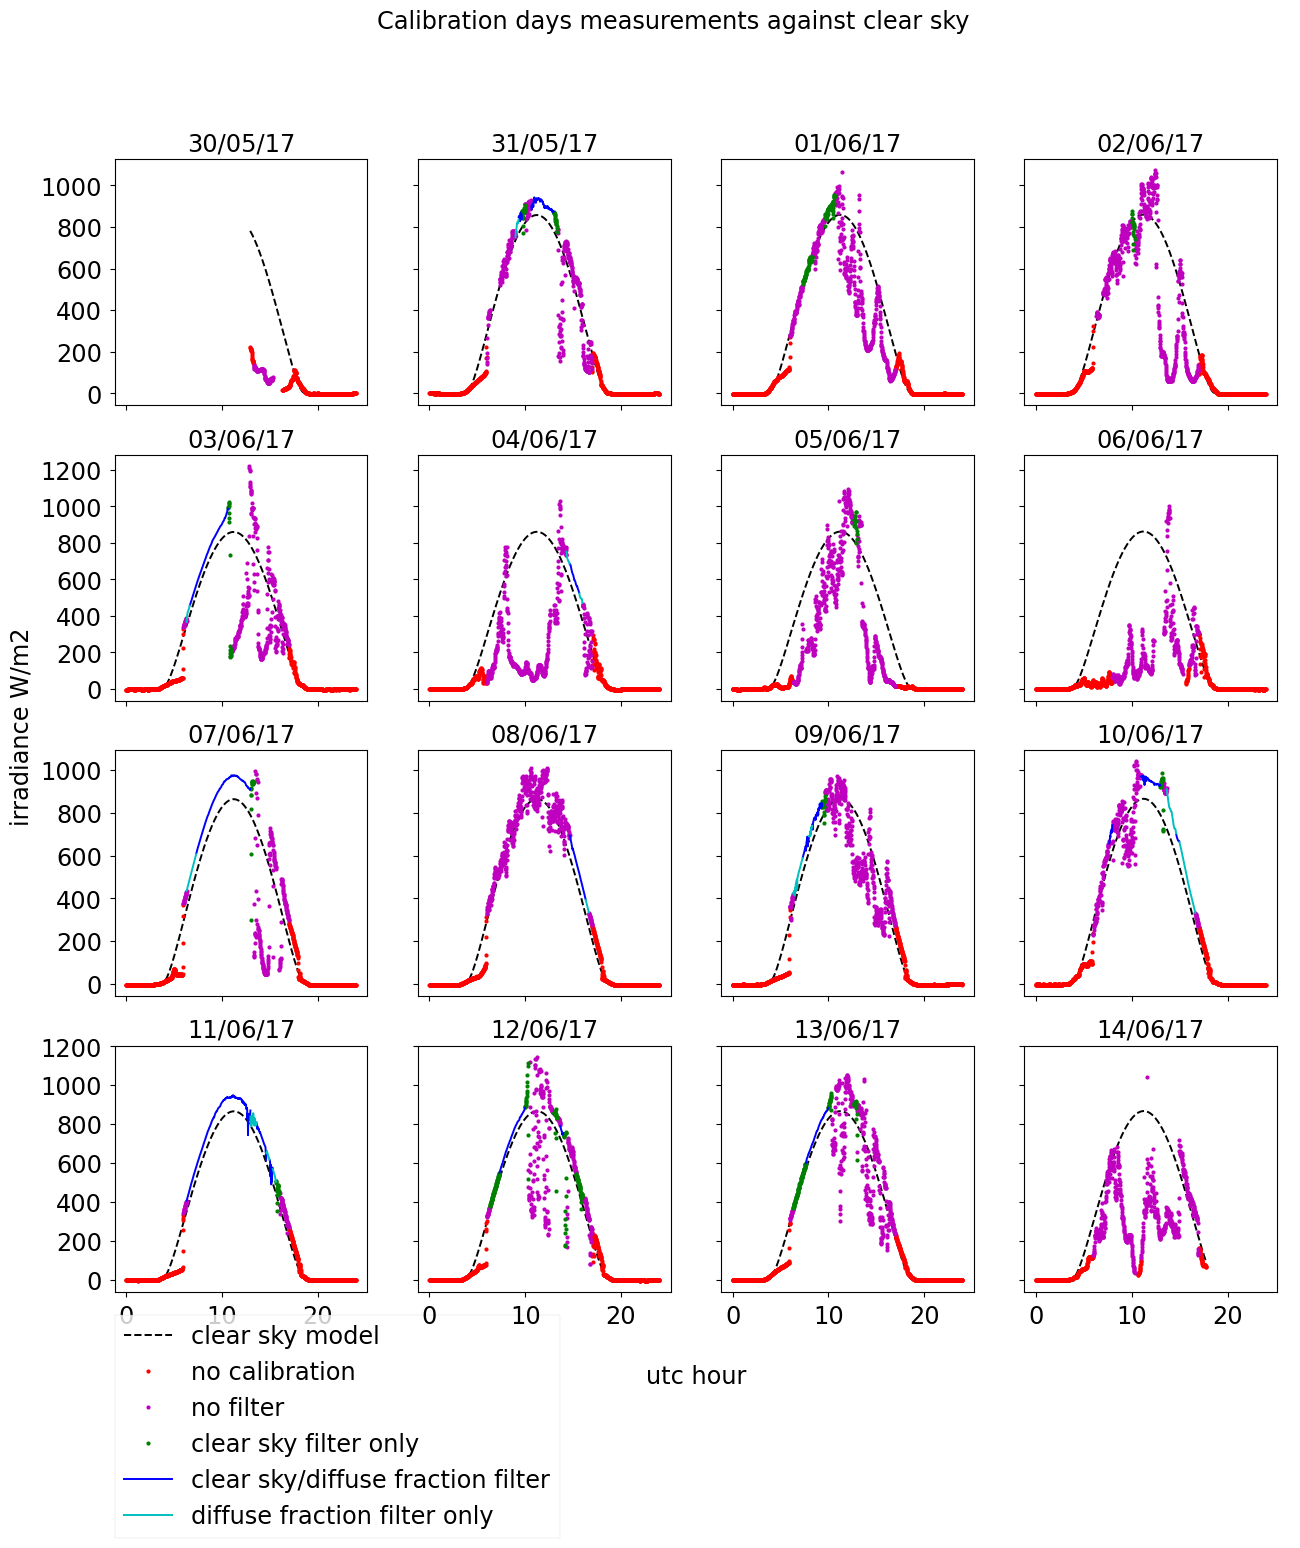

In [47]:
plot_stable_days(mss=labeled_dfs, sl=EURAC_SL, tzi='utc',
    markers =["k--","r.","m.", "g.", "b", "c"],
    lgn_labels = ["clear sky model", "no calibration", "no filter", "clear sky filter only", "clear sky/diffuse fraction filter",
                  "diffuse fraction filter only"],
    columns = ["irradiancetotalpoa","no_clb","clb_no_filter", "clb_flt_cs", "clb_flt_cs_df", "clb_flt_df"],
    label= "", #(Trentino Alto Adige, summer 2017)",
    loc=(0,0), bbox_to_anchor=(0,-1))


### Comparison of sensitivities 

In [57]:
columns = ["f_j", "f_j_std", "start"]
clb_flt = clb + " irradiance > 20 W/m2"
#taking all columns to review results
calibration_dfs = calibrations[clb_flt]["clb_series"]
#comparing to previous one, df have no same index, how left necessary
clb_flt = clb + " clear sky filter"
calibration_dfs = pd.merge(left=calibration_dfs, right=calibrations[clb_flt]["clb_series"][columns], suffixes=("","_cs"),
         left_on="start", right_on="start", how='left')
clb_flt = clb + " diffuse fraction < 0.2"
calibration_dfs = pd.merge(left=calibration_dfs, right=calibrations[clb_flt]["clb_series"][columns],
         suffixes=("","_df"), how='left',
         left_on="start", right_on="start")

In [59]:
#DEV NOTE 25/8/21 could be optimised as function since similar to previous one
clb_clm_ind = {
"clb_no_filter": (calibration_dfs.f_j>0)&(calibration_dfs.f_j_cs.isna())&(calibration_dfs.f_j_df.isna()),
"clb_flt_cs_df": (calibration_dfs.f_j_df>0)&(calibration_dfs.f_j_cs>0),
"clb_flt_df": (calibration_dfs.f_j_df>0)&(calibration_dfs.f_j_cs.isna()),
"clb_flt_cs": (calibration_dfs.f_j_df.isna())&(calibration_dfs.f_j_cs>0)}

for k, v in clb_clm_ind.items():
    calibration_dfs.loc[v,k+"_f_j"] = calibration_dfs.loc[v,"f_j"]
    calibration_dfs.loc[v,k+"_f_j_std"] = calibration_dfs.loc[v,"f_j_std"]

showing deviation of sensitivites probably not so important since expected to be less than 2%
rather a grouping maybe could be done
beware different days involved
not clear why a minute

In [ ]:
legend = decorators.use_default(plt.legend)

clb_empty = []
x = []
y = []
lgn_labels = []

for clb_flt in calibrations.keys():
    if "clb_series" in calibrations[clb_flt].keys():
        s = calibrations[clb_flt]["clb_series"]
        if len(s) > 0:
            if "eurac" not in clb_flt:
                plt.scatter(s.dt_quantile.apply(dtop.dt_to_hour).values,
                         s.f_j.values, label=clb_flt, alpha=0.5)
                lgn_labels += [clb_flt]
        else: clb_empty += [clb_flt]
    else: clb_empty += [clb_flt]

legend()
plt.show()

In [ ]:
legend = decorators.use_default(plt.legend)

clb_empty = []
x = []
y = []
lgn_labels = []

for clb_flt in calibrations.keys():
    if "clb_series" in calibrations[clb_flt].keys():
        s = calibrations[clb_flt]["clb_series"]
        if len(s) > 0:
            if ("clear sky" in clb_flt) or ("diffuse fraction" in clb_flt):
                plt.scatter(s.dt_quantile.apply(dtop.dt_to_hour).values,
                         s.f_j.values, label=clb_flt, alpha=0.5)
                lgn_labels += [clb_flt]
        else: clb_empty += [clb_flt]
    else: clb_empty += [clb_flt]

plt.legend()
plt.show()

In [ ]:
t = calibrations["outdoor kz11 e24 2017 clear sky filter"]["clb_series"]

In [ ]:
len(t[t.diffuse_fraction_median>0.2])

In [ ]:
len(t[t.diffuse_fraction_median<=0.2])

In [ ]:
for c in clb_empty: del calibrations[c]



ARCHIVED TESTING MODELS

#overview models which could be tested instead of 'kastenyoung1989'
_APPARENT_ZENITH_MODELS: List = ['kastenyoung1989', 'kasten1966', 'simple', 'pickering2002', 'youngirvine1967',
                                 'young1994', 'gueymard1993']
(EURAC_SL.latitude, EURAC_SL.longitude, EURAC_SL.surface_zenith, EURAC_SL.surface_azimuth,
 EURAC_SL.clear_sky_model, EURAC_SL.apparent_zenith_model, EURAC_SL.diffuse_model, EURAC_SL.poa_model)

ARCHIVED ASTM STEPS
#9060: 2018 40°, 60°, 70°, 80°
#ASTM G213 − 17 steps 2 degrees with +- 0.3 degree.
step_f = lambda x: (x // 2) *2 if abs(x % 2) <= 0.3 else None
#steps cannot be used since too few calibration points
srs_calibration_factors_2017["aoi_step"] = srs_calibration_factors_2017["aoi_median"].apply(step_f)
srs_calibration_factors_2017 = srs_calibration_factors_2017.reindex(sorted(srs_calibration_factors_2017.columns), axis=1)

ARCHIVED SHOWING UNCERTAINTY
fig, ax = plt.subplots(1, 1) #, sharex='col', sharey='row') #, figsize=FIGURE_FIGSIZE)
x = srs_calibration_factors_2017.aoi_median.unique()
y = f
sns.lineplot(ax=ax, x=x, y=y, color='r')

ARCHIVED COMPARISON EURAC

t0 = calibrations[clb+" eurac manual"]["labeled_df"]
t1 = calibrations[clb+" eurac auto"]["labeled_df"]
t0 = t0[t0.calibration>0]
t1 = t1[t1.calibration>0]

ARCHIVED COMPARISON BETWEEN AUTOMATIC AND MANUAL

t00 = calibrations[clb+" eurac manual"]["clb_series"]
t11 = calibrations[clb+" eurac auto"]["clb_series"]


#showing similarities between manual and automatic
#from mpl_toolkits.axes_grid1 import host_subplot
#host = host_subplot(111)
#par = host.twinx()
p0, = plt.plot(t00.dt_quantile, t00.f_j, "g", label=clb+" manual", alpha=0.5)
p1 = plt.plot(t11.dt_quantile, t11.f_j, "r", label=clb+" flt dff", alpha=0.5)
plt.show()